In [1]:
import os

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

gpu_on = True

if gpu_on :
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

    
# K.set_floatx('float64')

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from gan_module.data_loader.classification import BinaryClassifyDataloader as ClassifyDataloader
from tensorflow.keras.applications.inception_v3 import preprocess_input

from glob import glob

data_set_name = "detect_lvi"
target_size = (512,512)
interpolation = "bilinear"
batch_size = 1
dtype="float32"

train_image_path_list = glob(f"./datasets/{data_set_name}/train/*/*")
valid_image_path_list = glob(f"./datasets/{data_set_name}/valid/*/*")
test_image_path_list = glob(f"./datasets/{data_set_name}/test/*/*")
label_list = os.listdir(f"./datasets/{data_set_name}/train")

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}
train_data_loader = ClassifyDataloader(image_path_list=train_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,
                                       shuffle=False,
                                       dtype=dtype
)
valid_data_loader = ClassifyDataloader(image_path_list=valid_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                       
                                       shuffle=False,
                                       dtype=dtype
)
test_data_loader = ClassifyDataloader(image_path_list=test_image_path_list,
                                       label_to_index_dict=label_to_index_dict,
                                       batch_size=batch_size,
                                       preprocess_input=preprocess_input,
                                       target_size=target_size,
                                       interpolation=interpolation,                                      
                                       shuffle=False,
                                      dtype=dtype
)

In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import numpy as np
np.random.seed(1337)  # for reproducibility

DROPOUT_RATIO = 0.5

grad_cam = True
transfer_learning = True
train_mode = "include_depp_layer"
#  binary_sigmoid, categorical_sigmoid, categorical_softmax
activation = "binary_sigmoid"

# create the base pre-trained model~
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    classes=None,
    pooling=None,
    classifier_activation=None
)

if transfer_learning:
    if train_mode == "dense_only":
        base_model.trainable = False
    elif train_mode == "include_depp_layer":
        for layer in base_model.layers: 
            layer.trainable = False
            if layer.name == "mixed4":
                break


# add a global spatial average pooling layer
x = base_model.output
# (Batch_Size,?)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATIO)(x)
# let's add a fully-connected layer
# (Batch_Size,1)
x = Dense(1024, activation='relu')(x)
# (Batch_Size,1024)
x = Dropout(DROPOUT_RATIO)(x)

if grad_cam:
    x /= 2
if activation == "binary_sigmoid":
    predictions = Dense(1, activation='sigmoid', dtype="float32")(x)
    loss_function = BinaryCrossentropy(label_smoothing=0.01)
elif activation == "categorical_sigmoid":
    predictions = Dense(2, activation='sigmoid', dtype="float32")(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)
elif activation == "categorical_softmax":
    predictions = Dense(2, activation='softmax', dtype="float32")(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)

# this is the model we will train
model = Model(base_model.input, predictions)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

optimizer = Nadam(1e-3, clipnorm=1)


save_c = ModelCheckpoint(
    "./U_net/weights_{epoch:02d}_{loss:.4f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-9)
csv_logger = CSVLogger('./U_net/log.csv', append=False, separator=',')


def make_model_trainable(epoch, target_epoch):
    if epoch > target_epoch:
        model.trainable = True
        
make_trainable_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: make_model_trainable(epoch, target_epoch=10)
)



model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [6]:
# start_epoch = 0
# epochs = 200

# model.fit(
#     train_data_loader,
#     validation_data=valid_data_loader,
#     epochs=epochs,
#     callbacks=[reduceLROnPlat, save_c, csv_logger],
#     initial_epoch=start_epoch
# )

# Class Activation Map

In [64]:
import cv2
import os
import numpy as np

def imread(img_path, channel=None):
    img_byte_stream = open(img_path.encode("utf-8"), "rb")
    img_byte_array = bytearray(img_byte_stream.read())
    img_numpy_array = np.asarray(img_byte_array, dtype=np.uint8)
    img_numpy_array = cv2.imdecode(
        img_numpy_array, cv2.IMREAD_UNCHANGED)
    if channel == "rgb":
        img_numpy_array = cv2.cvtColor(
            img_numpy_array, cv2.COLOR_BGR2RGB)
    if len(img_numpy_array.shape) == 2:
        img_numpy_array = np.expand_dims(img_numpy_array, axis=-1)
    return img_numpy_array

from tensorflow import keras
import matplotlib.cm as cm

BASE_DTYPE = "float32"

def get_last_conv_name(model):
    layer_names = [layer.name for layer in model.layers]
    conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
    last_conv_name = conv_layer_name[-1]
    
    return last_conv_name

def get_img_array(img_path, channel="rgb", dtype=BASE_DTYPE):
    
    img_array = imread(img_path, channel="rgb")
    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Model input: model.input
    # Model output: [last_conv_layer_outputs, model.outputs]
    grad_model = keras.models.Model(
        model.input, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # compute
    # 1. last_conv_layer_output
    # 2. class_channel value in prediction
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # compute gradient 
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # compute gradient channel mean 
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # compute matmul(last_conv_layer_output, pooled_grads)
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image.open(cam_path))


def decode_classify_predictions(pred_array, index_to_label_dict):
    predicted_index = np.sum(np.argmax(preds, axis=1))
    predicted = index_to_label_dict[predicted_index]
    
    return predicted

def decode_binary_classify_predictions(pred_array, index_to_label_dict):
    predicted = np.round(pred_array)
    predicted = predicted.flatten()[0]
    return predicted

In [65]:
layer_names = [layer.name for layer in model.layers]
conv_layer_name = [layer_name for layer_name in layer_names if layer_name.find("conv") >= 0]
last_conv_name = conv_layer_name[-1]

print(last_conv_name)

conv2d_657


In [66]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_564 (BatchN (None, None, None, 3 96          conv2d_564[0][0]                 
__________________________________________________________________________________________________
activation_564 (Activation)     (None, None, None, 3 0           batch_normalization_564[0][0]    
____________________________________________________________________________________________

In [67]:
imported_weight_path = "./U_net/LVI_detect_classfication/binary_sigmoid/weights_1.0_1.0_InceptionV3_Imagenet_LVI_level2/weights_129_0.0012.hdf5"

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

import numpy as np
np.random.seed(1337)  # for reproducibility

DROPOUT_RATIO = 0.5

grad_cam = True
transfer_learning = True
train_mode = "include_depp_layer"
#  binary_sigmoid, categorical_sigmoid, categorical_softmax
activation = "binary_sigmoid"

# create the base pre-trained model~
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    classes=None,
    pooling=None,
    classifier_activation=None
)

if transfer_learning:
    if train_mode == "dense_only":
        base_model.trainable = False
    elif train_mode == "include_depp_layer":
        for layer in base_model.layers: 
            layer.trainable = False
            if layer.name == "mixed4":
                break


# add a global spatial average pooling layer
x = base_model.output
# (Batch_Size,?)
x = GlobalAveragePooling2D()(x)
x = Dropout(DROPOUT_RATIO)(x)
# let's add a fully-connected layer
# (Batch_Size,1)
x = Dense(1024, activation='relu')(x)
# (Batch_Size,1024)
x = Dropout(DROPOUT_RATIO)(x)

if grad_cam:
    x *= 1e-1
if activation == "binary_sigmoid":
    predictions = Dense(1, activation='sigmoid', dtype="float32")(x)
    loss_function = BinaryCrossentropy(label_smoothing=0.01)
elif activation == "categorical_sigmoid":
    predictions = Dense(2, activation='sigmoid', dtype="float32")(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)
elif activation == "categorical_softmax":
    predictions = Dense(2, activation='softmax', dtype="float32")(x)
    loss_function = CategoricalCrossentropy(label_smoothing=0.01)

# this is the model we will train
model = Model(base_model.input, predictions)
model.load_weights(imported_weight_path)
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [68]:
model.evaluate(test_data_loader)

1469/1469 [==============================] - 41s 26ms/step - loss: 0.1767 - accuracy: 0.9973


[0.17671674489974976, 0.9972770810127258]

In [69]:
temp = model.predict(test_data_loader)

In [70]:
group_1 = np.where(temp > 0.5)[0]
group_2 = np.where(temp != 1)[0]
not_confirm = np.intersect1d(group_1, group_2)

In [71]:
np.where(temp == 1)[0]

array([], dtype=int64)

In [72]:
not_confirm

array([  32,  471,  769,  770,  771,  772,  773,  774,  775,  776,  777,
        778,  779,  780,  781,  782,  783,  784,  785,  786,  787,  788,
        789,  790,  791,  792,  793,  794,  795,  796,  797,  798,  799,
        800,  801,  802,  803,  804,  805,  806,  807,  808,  809,  810,
        811,  812,  813,  814,  815,  816,  817,  818,  819,  820,  821,
        822,  823,  824,  825,  826,  827,  828,  829,  830,  831,  832,
        833,  834,  835,  836,  837,  838,  839,  840,  841,  842,  843,
        844,  845,  846,  847,  848,  849,  850,  851,  852,  853,  854,
        855,  856,  857,  858,  859,  860,  861,  862,  863,  864,  865,
        866,  867,  868,  869,  870,  871,  872,  873,  874,  875,  876,
        877,  878,  879,  880,  881,  882,  883,  884,  885,  886,  887,
        888,  889,  890,  891,  892,  893,  894,  895,  896,  897,  898,
        899,  900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
        910,  911,  912,  913,  914,  915,  916,  9

./datasets/detect_lvi/test\LVI_negative\126_LVI_negative_1.png


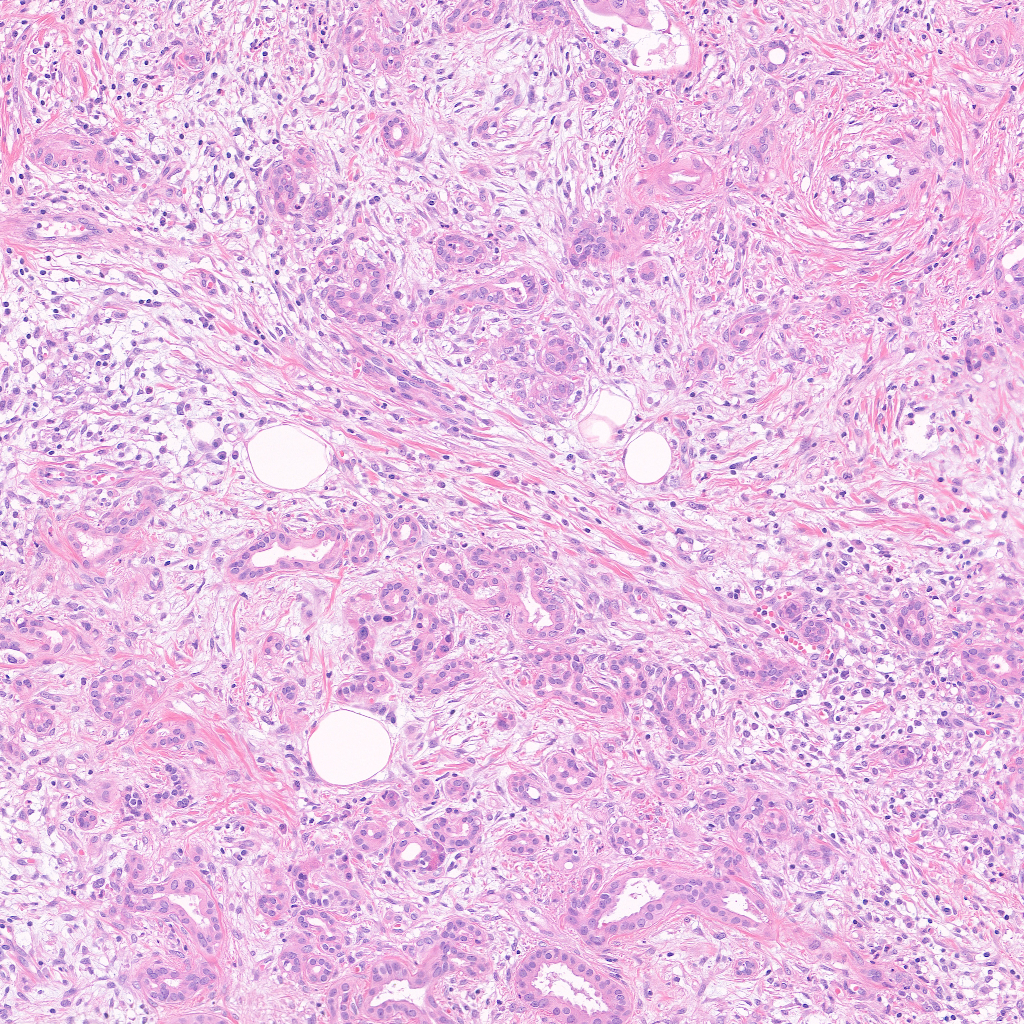

In [77]:
from PIL import Image

img_index = 1

test_image_path = test_image_path_list[img_index]
print(test_image_path)
display(Image.open(test_image_path))

[[0.15609352]]
Predicted: 0.0


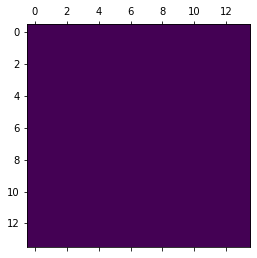

In [78]:
last_conv_layer_name = "mixed10"

from matplotlib import pyplot as plt
# Prepare image
img_array = get_img_array(test_image_path)
img_array_normalized = test_data_loader[img_index][0]
# img_array_normalized = (img_array / 127.5) - 1

# Print what the top predicted class is
preds = model.predict(img_array_normalized)
print(preds)
predicted_label = decode_binary_classify_predictions(preds, index_to_label_dict)
pred_index = None
# pred_index = label_to_index_dict[predicted_label]

print(f"Predicted: {predicted_label}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array_normalized, model, last_conv_layer_name, pred_index=pred_index)

# Display heatmap
plt.matshow(heatmap)
plt.show()

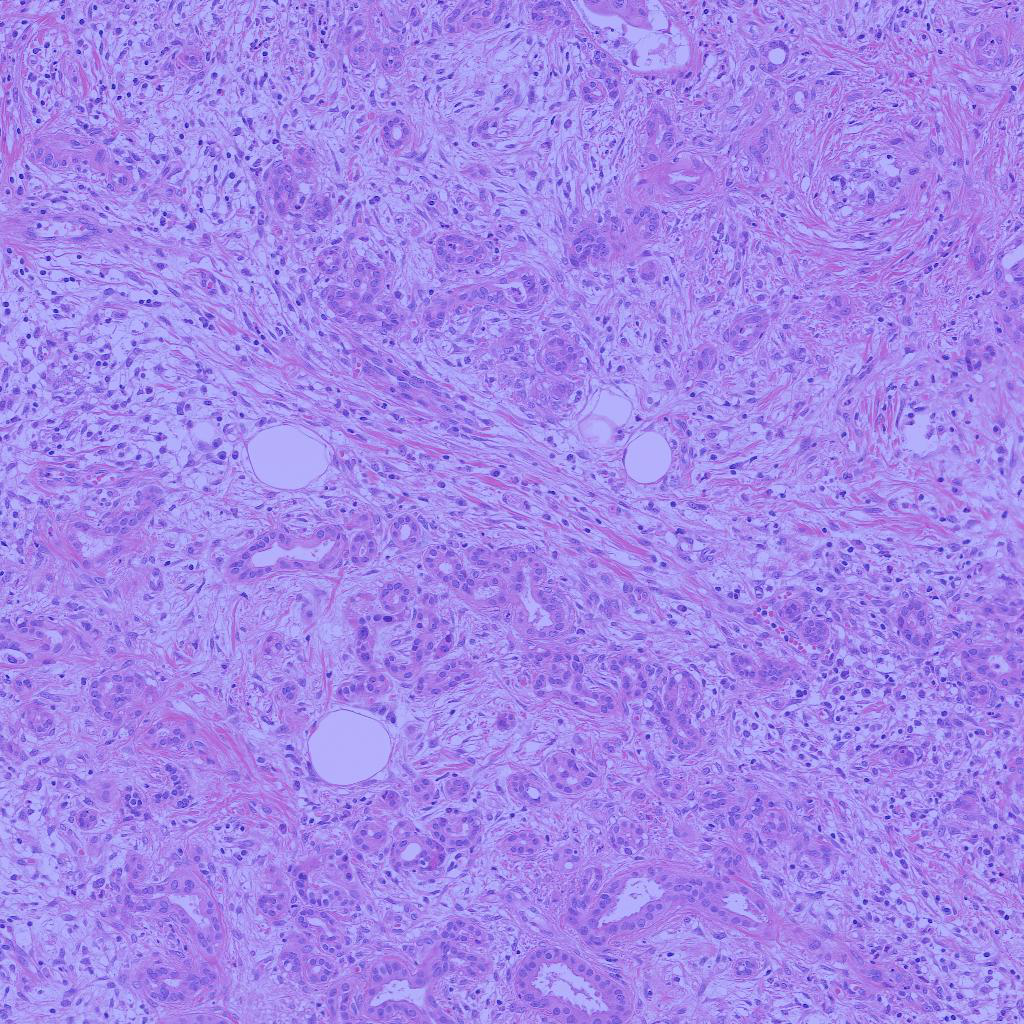

In [79]:
save_and_display_gradcam(test_image_path, heatmap)

In [76]:
pred_index=None

# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = keras.models.Model(
    [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
)

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array_normalized)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel * 0.99, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [40]:
last_conv_layer_output.shape

TensorShape([14, 14, 2048])

In [41]:
pooled_grads

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([4.7515691e-06, 8.7871786e-06, 4.2414981e-06, ..., 2.2488302e-05,
       1.7208977e-05, 1.6877316e-06], dtype=float32)>

In [ ]:
from copy import deepcopy

base_weight = deepcopy(model.weights)
model.load_weights("./U_net/weights_32_0.0481.hdf5")
loaded_weihgt = deepcopy(model.weights)

# Compute in precision float64, It has small 1 value

In [16]:
np.where(temp == 1)[0]

array([ 822,  834,  836,  838,  845,  866,  877,  888,  899,  910,  952,
        964,  966,  967,  968,  969,  970,  971,  972,  973,  974,  975,
        976,  977,  980,  981,  983,  985,  996, 1017, 1018, 1020, 1027,
       1050, 1053, 1055, 1060, 1065, 1071, 1109, 1110, 1111, 1112, 1113,
       1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124,
       1125, 1126, 1127, 1128, 1146, 1148, 1149, 1150, 1155, 1157, 1159,
       1161, 1164, 1165, 1167, 1168, 1169, 1170, 1171, 1172, 1175, 1176,
       1177, 1178, 1180, 1181, 1182, 1183, 1184, 1187, 1188, 1189, 1190,
       1191, 1193, 1194, 1199, 1201, 1204, 1205, 1209, 1210, 1211, 1212,
       1213, 1214, 1216, 1217, 1219, 1220, 1221, 1223, 1225, 1227, 1228,
       1243, 1250, 1266, 1272, 1276, 1277, 1279, 1281, 1282, 1283, 1284,
       1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1317, 1319, 1320,
       1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1354, 1363, 1365,
       1366, 1368, 1373, 1377, 1379, 1380, 1382, 13

In [14]:
not_confirm

array([  32,  471,  769,  770,  771,  772,  773,  774,  775,  776,  777,
        778,  779,  780,  781,  782,  783,  784,  785,  786,  787,  788,
        789,  790,  791,  792,  793,  794,  795,  796,  797,  798,  799,
        800,  801,  802,  803,  804,  805,  806,  807,  808,  809,  810,
        811,  812,  814,  815,  816,  817,  818,  820,  821,  823,  824,
        825,  826,  827,  828,  829,  830,  831,  832,  833,  835,  837,
        839,  840,  841,  842,  843,  844,  846,  847,  848,  849,  850,
        851,  852,  853,  854,  855,  856,  857,  858,  859,  860,  861,
        862,  863,  864,  865,  867,  868,  869,  870,  871,  872,  873,
        874,  875,  876,  878,  879,  880,  881,  882,  883,  884,  885,
        886,  887,  889,  890,  891,  892,  893,  894,  895,  896,  897,
        898,  900,  901,  902,  903,  904,  905,  906,  907,  908,  909,
        911,  912,  913,  914,  915,  916,  917,  918,  919,  920,  921,
        922,  923,  924,  925,  926,  927,  928,  9

# Compute in precision float32, It has many 1 value

In [13]:
np.where(temp == 1)[0]

array([ 771,  773,  776,  777,  779,  780,  781,  782,  783,  784,  785,
        786,  787,  788,  789,  790,  791,  793,  794,  795,  796,  797,
        798,  799,  800,  801,  802,  803,  805,  806,  807,  809,  811,
        814,  816,  817,  821,  822,  825,  827,  828,  829,  833,  834,
        835,  836,  837,  838,  839,  840,  841,  842,  843,  844,  845,
        846,  849,  850,  851,  852,  853,  854,  855,  856,  857,  858,
        859,  861,  862,  863,  864,  865,  866,  867,  868,  869,  872,
        873,  874,  875,  876,  877,  878,  879,  880,  881,  882,  883,
        884,  886,  887,  888,  889,  890,  891,  892,  893,  894,  895,
        896,  897,  899,  910,  913,  922,  923,  925,  927,  933,  935,
        944,  945,  946,  947,  948,  949,  950,  951,  952,  953,  954,
        955,  956,  957,  958,  959,  960,  961,  962,  963,  964,  965,
        966,  967,  968,  969,  970,  971,  972,  973,  974,  975,  976,
        977,  978,  979,  980,  981,  982,  983,  9

In [14]:
not_confirm

array([  32,  471,  769,  770,  772,  774,  775,  778,  792,  804,  808,
        810,  812,  815,  818,  820,  823,  824,  826,  830,  831,  832,
        847,  848,  860,  870,  871,  885,  898,  900,  901,  902,  903,
        904,  905,  906,  907,  908,  909,  911,  912,  914,  915,  916,
        917,  918,  919,  920,  921,  924,  926,  928,  929,  930,  931,
        932,  934,  936,  937,  938,  939,  940,  941,  942,  943, 1011,
       1031, 1032, 1033, 1039, 1043, 1045, 1048, 1049, 1054, 1068, 1069,
       1072, 1074, 1075, 1076, 1078, 1082, 1083, 1085, 1086, 1087, 1088,
       1106, 1229, 1230, 1231, 1232, 1233, 1235, 1236, 1237, 1238, 1239,
       1240, 1241, 1242, 1252, 1256, 1261, 1263, 1274, 1285, 1286, 1287,
       1290, 1291, 1292, 1293, 1295, 1296, 1297, 1298, 1299, 1300, 1302,
       1304, 1305, 1306, 1307, 1318, 1389, 1390, 1391, 1393, 1394, 1396,
       1398, 1399, 1401, 1412, 1449, 1450, 1451, 1452, 1453, 1454, 1456,
       1457, 1458, 1460, 1461, 1462, 1463, 1464, 14